# Homogeneous model optimization using an evolutionary approach

In the previous tutorial, we used a grid search to fit the parameters of a homogeneous rWW model to the empirical data of our example subject.
Here, we will use an evolutionary optimization approach for the same goal.

While grid search systematically samples the entire parameter space (at a predefined resolution), evolutionary optimizers explore the parameter space more selectively. They operate through a series of **generations** (or **iterations**) that iteratively move toward the optimal region. Typically, the optimization starts with a random distribution of **particles** across the parameter space. Each particle represents a set of parameters, for which a simulation is run and a cost is calculated based on the empirical target data. The cost function of the particles in one generation influences the sampling of the next generation, iteratively guiding the search toward regions that minimize the cost.

The cuBNM toolbox supports any optimizer implemented in the `pymoo` Python package ([see the list here](https://pymoo.org/algorithms/list.html)). However, it features the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) as a selected optimization algorithm that has been shown to perform well in fitting brain network models (BNMs) \[[Wischnewski et al. 2022](https://doi.org/10.1038/s41598-022-07860-7)\].

In this tutorial, we will run a CMA-ES optimization to fit the parameters of the same homogeneous rWW model used previously (with three free parameters: $G$, $w^{EE}$, and $w^{EI}$). The optimization will be allowed to run for a maximum of 120 generations with 128 particles (simulations) per generation, resulting in up to 15,360 simulations. However, the optimization will terminate earlier if convergence is achieved before reaching the maximum number of generations.

## Running and saving the CMA-ES optimization

First, we'll load the example structural connectivity (SC) and target empirical BOLD data, which is the same as the data used in the previous tutorials.

In [1]:
from cubnm import datasets

# load structural connectome
sc = datasets.load_sc('strength', 'schaefer-100', 'group-train706')
# load empirical FC tril and FCD tril
emp_fc_tril = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)
emp_fcd_tril = datasets.load_fcd('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=True)

Next, we define the simulation options, similar to those used in the grid search. To reduce the clutter in the printed output, here we set `sim_verbose` to `False`.

In [2]:
sim_options = dict(
    duration=900,
    bold_remove_s=30,
    TR=0.72,
    sc=sc,
    sc_dist=None,
    dt='0.1',
    bw_dt='1.0',
    ext_out=True,
    states_ts=False,
    states_sampling=None,
    noise_out=False,
    sim_seed=0,
    noise_segment_length=30,
    gof_terms=['+fc_corr', '-fcd_ks'],
    do_fc=True,
    do_fcd=True,
    window_size=30,
    window_step=5,
    fcd_drop_edges=True,
    exc_interhemispheric=True,
    bw_params='heinzle2016-3T',
    sim_verbose=False,
    do_fic=True,
    max_fic_trials=0,
    fic_penalty_scale=0.5,
)

We now define the optimization problem using `BNMProblem`, just as we did for the grid search.

In [3]:
from cubnm import optimize

problem = optimize.BNMProblem(
    model = 'rWW',
    params = {
        'G': (0.001, 10.0), 
        'wEE': (0.001, 5.0),
        'wEI': (0.001, 5.0)
    },
    emp_fc_tril = emp_fc_tril,
    emp_fcd_tril = emp_fcd_tril,
    out_dir = './cmaes_homo',
    **sim_options
)

Here we specified the model (`model`), the free parameters to explore along with their ranges (`params`), the empirical BOLD data we want to fit the simulations to (`emp_bold`), and the simulation options defined above (`**sim_options`).

We now create a CMA-ES optimizer (`CMAESOptimizer`) object and define its properties.

In [4]:
cmaes = optimize.CMAESOptimizer(    
    popsize=128,
    n_iter=120, 
    seed=1,
    algorithm_kws=dict(tolfun=5e-3),
    print_history=False
)

We plan to run a maximum of `n_iter=120` iterations, with a population size of `popsize=128` simulations/particles per iteration.

Since there is some randomness in how the optimizer samples the parameter space, we set a random `seed=1` to ensure reproducibility. In practice, it is recommended to repeat CMA-ES runs with different seeds to avoid convergence to local optima.

The `algorithm_kws` argument specifies additional settings for the optimizer. Here, `tolfun=5e-3` defines the tolerance for early stopping. If the cost function does not improve by more than 0.005 across recent generations or across the particles of the last generation, the optimization will terminate early. (For more details, see [Hansen et al. 2016](https://arxiv.org/pdf/1604.00772)).

We also set `print_history` to `False` for a cleaner output in this tutorial. When it is set to `True` (default) while the optimization is run, the history of particles including their parameters and cost function components are printed.

Next, we assign the optimization `problem` to the CMA-ES optimizer `cmaes` using the `setup_problem()` method:

In [5]:
cmaes.setup_problem(problem)

Then, run the optimization and save its results (Note that this will take a while):

In [6]:
%%time
# run the optimization
cmaes.optimize()

# save the results
out_path = cmaes.save()

Initializing GPU session...
took 5.317800 s
Running 128 simulations...
took 39.963275 s
Current session is already initialized
Running 128 simulations...
took 39.875602 s
Current session is already initialized
Running 128 simulations...
took 40.863914 s
Current session is already initialized
Running 128 simulations...
took 39.964478 s
Current session is already initialized
Running 128 simulations...
took 40.810962 s
Current session is already initialized
Running 128 simulations...
took 40.159277 s
Current session is already initialized
Running 128 simulations...
took 40.868380 s
Current session is already initialized
Running 128 simulations...
took 39.868163 s
Current session is already initialized
Running 128 simulations...
took 40.867071 s
Current session is already initialized
Running 128 simulations...
took 39.878983 s
Current session is already initialized
Running 128 simulations...
took 39.881536 s
Current session is already initialized
Running 128 simulations...
took 40.686434 s

We can see that the optimizer converged and stopped earlier than the specified maximum 120 iterations. 

<div class="alert alert-info">
<p>
Note: At the end of the CMA-ES optimization (if convergence is reached), the algorithm samples a single final particle in the last generation, which represents its best estimate of the optimal point. However, the actual optimal simulation (`cmaes.opt`) is defined as the particle with the lowest cost across the entire optimization history (`cmaes.history`). As a result, the best estimate from the final generation and the true optimum found during the search may differ.
</p>
</div>


When `cmaes.save()` is called, the optimal simulation is re-run so that its simulated data can be saved to disk. Similar to the grid search, the simulated data, parameters and cost function components of the optimal simulation, as well as the optimizer history, simulation and optimization configurations (including SC and target FC/FCD) are saved to disk. For a detailed description of the saved files, see the [grid search tutorial](grid_search.ipynb).

## Visualization of the optimization history

The parameters of all simulations (particles) run during the optimization, along with their associated cost function and its components, are stored in `cmaes.history`.

In [7]:
cmaes.history

,index,G,wEE,wEI,cost,+fc_corr,-fcd_ks,+gof,-fic_penalty,gen
0,0,5.762320,3.271355,0.010757,1.462166,-0.027978,-0.934189,-0.962166,-0.500000,1
1,1,4.339865,2.576386,1.269945,0.470941,0.337145,-0.780717,-0.443572,-0.027368,1
2,2,3.187247,1.375780,1.942122,0.534352,0.320105,-0.854457,-0.534352,0.000000,1
3,3,5.701398,1.735285,3.053364,0.427838,0.338539,-0.765879,-0.427340,-0.000498,1
4,4,0.752408,1.572957,0.488748,1.101664,0.183841,-0.929322,-0.745481,-0.356184,1
...,...,...,...,...,...,...,...,...,...,...
4220,124,4.306496,0.003970,0.417351,-0.124178,0.299727,-0.140216,0.159511,-0.035333,33
4221,125,4.311999,0.002482,0.416862,-0.124749,0.299531,-0.139272,0.160259,-0.035509,33
4222,126,4.418797,0.001383,0.423870,-0.124501,0.300200,-0.138962,0.161238,-0.036737,33
4223,127,4.173920,0.002723,0.407253,-0.124915,0.298655,-0.140054,0.158601,-0.033686,33


We can visualize how negative cost evolved over the course of CMA-ES optimization. Here, to indicate better simulations with higher values, rather than the cost function we will visualize negative cost function.

<Axes: xlabel='Generation', ylabel='- Cost'>

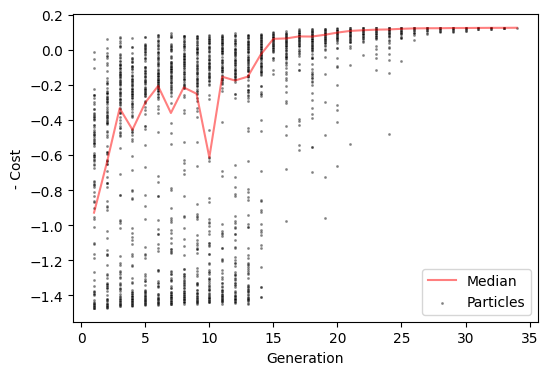

In [8]:
cmaes.plot_history('-cost')

We can also visualize how the particles moved through the 3D parameter space (`'G'`, `'wEE'`, `'wEI'`) across generations. We will create a GIF showing the progression of particles over time.

In [10]:
import matplotlib.pyplot as plt
import imageio
import os
import tempfile

free_params = ['G', 'wEE', 'wEI']
frames = []
temp_dir = tempfile.mkdtemp()

# using consistent color ranges and axes across frames
vmin = -cmaes.history['cost'].max()
vmax = -cmaes.history['cost'].min()

# loop through each generation and save a frame
for gen in range(cmaes.history['gen'].min(), cmaes.history['gen'].max() + 1):
    # plot parameter space in current generation
    fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': '3d'})
    cmaes.plot_space(
        '-cost', 
        title=f'Generation {gen}', 
        gen=gen,
        config=dict(
            alpha=0.6,
            size=20,
            vmin=vmin,
            vmax=vmax,
            zoom=0.85,
            azim=30,
        ),
        ax=ax
    )
    # save image
    fig.tight_layout()
    frame_path = os.path.join(temp_dir, f'frame_{gen}.png')
    plt.savefig(frame_path)
    frames.append(frame_path)
    plt.close(fig)

# create the GIF
images = [imageio.imread(frame) for frame in frames]
imageio.mimsave('./cmaes_3d.gif', images, fps=2, loop=0)

/tmp/ipykernel_7961/4201713235.py:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(frame) for frame in frames]


![CMAES GIF](./cmaes_3d.gif)

This visualization shows how over successive generations the particles are gradually concentrated into a specific region of the parameter space.

## Visualization of the optimal simulation

Lastly, we will visualize the simulated FC and FCD of the optimal simulation and compare them to the empirical data.

We can then plot the empirical FC next to the simulated FC. Note that at the end of the single-objective optimizations such as CMA-ES, `cmaes.problem.sim_group` contains a single simulation which is the optimum, therefore we can access its data by providing `0` as the simulation index.

Text(0.5, 1.0, 'Simulated FC')

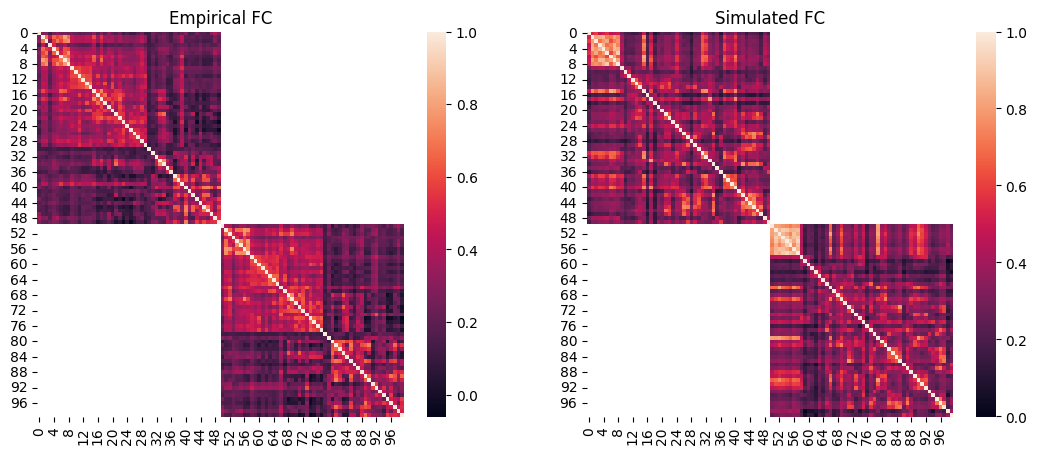

In [11]:
import seaborn as sns

# load the squared form of the empirical FC
emp_fc = datasets.load_fc('schaefer-100', 'group-train706', exc_interhemispheric=True, return_tril=False)

opt_idx = 0

# load squared form of optimal simulated FC
sim_fc = cmaes.problem.sim_group.get_sim_fc(opt_idx)

# plot it next to the empirical FC
fig, axes = plt.subplots(1, 2, figsize=(13, 5))
sns.heatmap(emp_fc, ax=axes[0])
axes[0].set_title("Empirical FC")
sns.heatmap(sim_fc, ax=axes[1])
axes[1].set_title("Simulated FC")

FC correlation = 0.29896163731250813


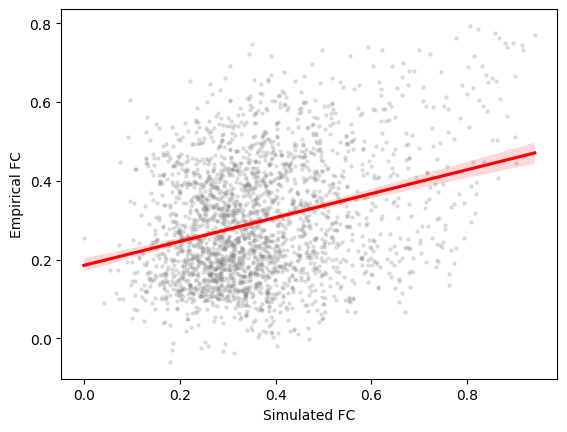

In [12]:
import scipy.stats
# regression plot
fig, ax = plt.subplots()
sns.regplot(
    x=cmaes.problem.sim_group.sim_fc_trils[opt_idx],
    y=emp_fc_tril,
    scatter_kws=dict(s=5, alpha=0.2, color="grey"),
    line_kws=dict(color="red"),
)
ax.set_xlabel("Simulated FC")
ax.set_ylabel("Empirical FC")
# calculate Pearson correlation
print(f"FC correlation = {scipy.stats.pearsonr(cmaes.problem.sim_group.sim_fc_trils[opt_idx], emp_fc_tril).statistic}")

In addition to static FC, we can also plot the simulated FCD matrix distribution next to the empirical data, and calculate their Kolmogorov-Smirnov distance:

FCD KS distance = 0.1394383198497019


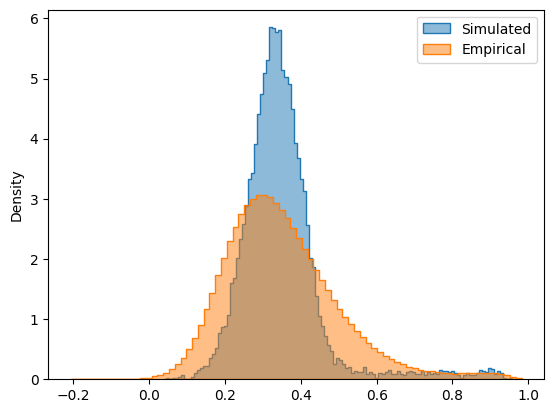

In [13]:
# plot the distributions next to each other
sns.histplot(cmaes.problem.sim_group.sim_fcd_trils[opt_idx], element='step', alpha=0.5, label='Simulated', stat='density')
ax = sns.histplot(emp_fcd_tril, element='step', alpha=0.5, label='Empirical', stat='density')
ax.legend()

# calculate KS distance
print(f"FCD KS distance = {scipy.stats.ks_2samp(emp_fcd_tril, cmaes.problem.sim_group.sim_fcd_trils[opt_idx]).statistic}")

The simulated and empirical FC and FCD are quantitatively compared using the FC correlation (`+fc_corr`) and FCD KS distance (`-fcd_ks`). These metrics, along with the other cost function components and the parameters of the optimal simulation, are stored in `cmaes.opt`:

In [14]:
cmaes.opt

index           38.000000
G                4.239551
wEE              0.001027
wEI              0.411252
cost            -0.125055
+fc_corr         0.298962
-fcd_ks         -0.139438
+gof             0.159523
-fic_penalty    -0.034468
gen             32.000000
Name: 4006, dtype: float64

We can observe that this optimal simualtion has a lower cost function and higher goodness-of-fit compared to the optimal point found in the [grid search tutorial](grid_search.ipynb). This shows the advantage of using evolutionary optimization algorithms over brute-force grid search. Evolutionary optimizers are not limited by a fixed sampling resolution, and rather, can explore parameter values more flexibly and precisely, allowing them to potentially reach better optima.

<div class="alert alert-info">
<p>
Note: This improved fit came at the cost of higher compute time. On an A100 GPU, the 1000-simulation grid search completed in ~3.5 minutes, while the CMA-ES optimization took nearly 10× longer. This is partly due to the sequential nature of evolutionary optimizers (generations can't be run in parallel), and also because the total number of simulations here was ~5× higher. This raises the question: when working with a low-dimensional model where grid search is still feasible, might that be a more cost-effective choice?
</p>
</div>